In [473]:
from WindPy import w
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

In [474]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [475]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [708]:
DATA_DIR = 'D:/Data/stocks'
INDEX_COMP_DIR = 'D:/Data/index-component'
code = '000402.SZ'
fname = '%s/%s.xlsx'%(DATA_DIR, code)

In [709]:
df = pd.read_excel(fname, index_col=0)

In [710]:
df.head()

,amt,close,dealnum,free_turn,mfd_buyamt_a,mfd_sellamt_a,mkt_freeshares,turnover,volume,vwap
2015-01-05 00:00:00.005,2.290106e+09,11.449030,71026,8.581503,202753434.0,307754891.0,2.568462e+10,0.089163,181409558.0,11.895640
2015-01-06 00:00:00.005,1.506576e+09,10.751723,57236,6.222206,116244158.0,215909811.0,2.412029e+10,0.062461,131534957.0,10.793005
2015-01-07 00:00:00.005,7.360202e+08,10.676338,31869,3.090137,24246997.0,68144981.0,2.395117e+10,0.030730,65324265.0,10.617141
2015-01-08 00:00:00.005,7.290254e+08,10.271146,33209,3.121742,23812338.0,92433673.0,2.304217e+10,0.031639,65992377.0,10.409775
2015-01-09 00:00:00.005,8.447881e+08,10.271146,34405,3.600042,95653791.0,58500408.0,2.304217e+10,0.036663,76103462.0,10.460100


# 收益率

In [711]:
df['ret'] = df['close'].pct_change()
df['20-day ret'] = df['ret'].rolling(window=20).mean()
df['20-day close'] = df['close'].rolling(window=20).mean()
df['20-day volume'] = df['volume'].rolling(window=20).mean()
df['20-day mfd_buyamt_a'] = df['mfd_buyamt_a'].rolling(window=20).sum()
df['20-day mfd_sellamt_a'] = df['mfd_sellamt_a'].rolling(window=20).sum()

# 波动率

In [712]:
df['volatility'] = df['ret'].rolling(window=20).std()

# 近一个月成交额

In [713]:
df['20-day amt'] = df['amt'].rolling(window=20).sum()

# 近一个月换手率

In [714]:
df['20-day turnover'] = df['turnover'].rolling(window=20).sum()

# 自由流通市值 / 价格

In [715]:
df['share_div_price'] = df['mkt_freeshares'] / df['close']

# Amihud(2002)的非流动性比率
单位成交额的收益率

In [716]:
df['amihud'] = np.abs(df['ret']) / df['amt']
df['20-day amihud'] = df['amihud'].rolling(window=20).mean()

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in absolute
  if __name__ == '__main__':


# 流动性指标
* 自由流通市值 / 价格
* 近一个月成交额
* 近一个月换手率
* 近一个月价格均值
* 近一个月收益率均值
* 波动率

In [717]:
indicators = ['share_div_price',
              '20-day amt', 
              '20-day turnover', 
              '20-day close', 
              '20-day ret', 
              'volatility',
              '20-day amihud',
              '20-day mfd_buyamt_a',
              '20-day mfd_sellamt_a',
             ]

In [718]:
X = df[indicators].fillna(df[indicators].mean())

# 标准化

In [719]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# PCA

In [720]:
pca = PCA()

In [721]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### 主成分贡献率

In [722]:
pca.explained_variance_ratio_

array([  6.05195439e-01,   1.62926417e-01,   1.19779041e-01,
         6.96651281e-02,   2.20486511e-02,   1.25865020e-02,
         6.45638209e-03,   1.12280980e-03,   2.19629522e-04])

### Eigen value

In [723]:
centered_matrix = X_scaled - X_scaled.mean(axis=0)
cov = np.dot(centered_matrix.T, centered_matrix)
eigvals, eigvecs = np.linalg.eig(cov)

In [724]:
eigvals

array([  3.03384474e+03,   8.16750130e+02,   6.00452332e+02,
         3.49231287e+02,   1.10529888e+02,   6.30961344e+01,
         3.23658434e+01,   1.10100280e+00,   5.62864550e+00])

# 计算流动性指标
$$F = \sum_{k=1}^{m} \frac{\lambda_k}{\sum_{i=1}^{m}\lambda_k}\times F_k$$

In [725]:
m = 4

In [726]:
F = np.dot(X_scaled, eigvecs[:, :m])

In [727]:
lambdas = eigvals[:m]
lambdas = lambdas / lambdas.sum()

In [728]:
F_score = np.dot(F, lambdas.T)

In [729]:
Fdf = pd.DataFrame({'F': F_score, 
                   'close': df['close'].values}, index=X.index)

In [730]:
Fdf['close_adj'] = preprocessing.StandardScaler().fit_transform(Fdf['close'].values.reshape(1, -1).T)

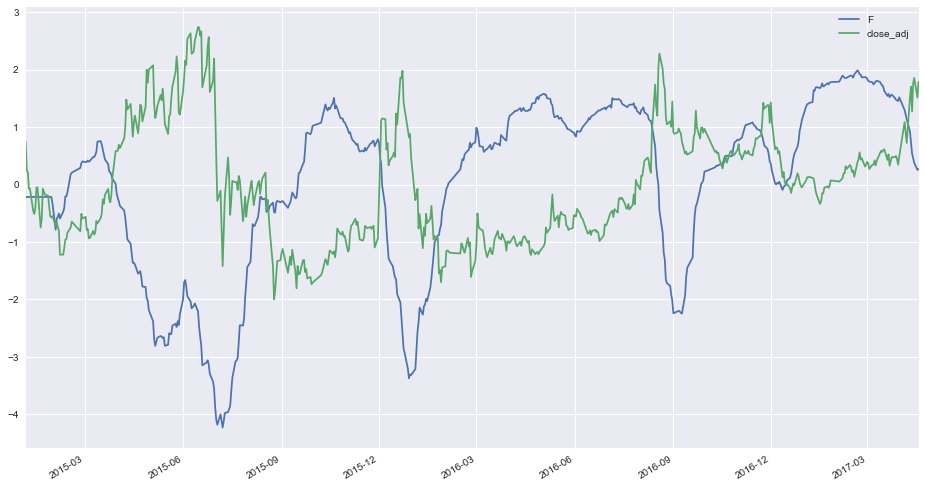

In [731]:
plt.figure(figsize=(16, 9))
Fdf['F'].plot(legend=True)
Fdf['close_adj'].plot(legend=True)

In [660]:
k = 5
Fdf['ret'] = Fdf['close'].pct_change(k).shift(-k)

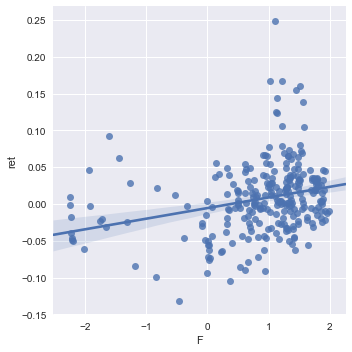

In [661]:
sns.lmplot(x='F', y='ret', data=Fdf[Fdf.index >= '2016-03-01'])

In [662]:
Fdf['ret'].corr(Fdf['F'])

0.22886300383308703

In [663]:
def liquidity_value(X):
    m = 3
    centered_matrix = X - X.mean(axis=0)
    cov = np.dot(centered_matrix.T, centered_matrix)
    eigvals, eigvecs = np.linalg.eig(cov)
    F = np.dot(X, eigvecs[:, :m])
    lambdas = eigvals[:m]
    lambdas = lambdas / lambdas.sum()
    F_score = np.dot(F, lambdas.T)
    return F_score

In [664]:
F_score = liquidity_value(X_scaled)

In [665]:
Fdf = pd.DataFrame({'F': F_score, 'close': df['close'].values}, index=X.index)

In [666]:
Fdf['close_adj'] = preprocessing.StandardScaler().fit_transform(Fdf['close'].values.reshape(1, -1).T)

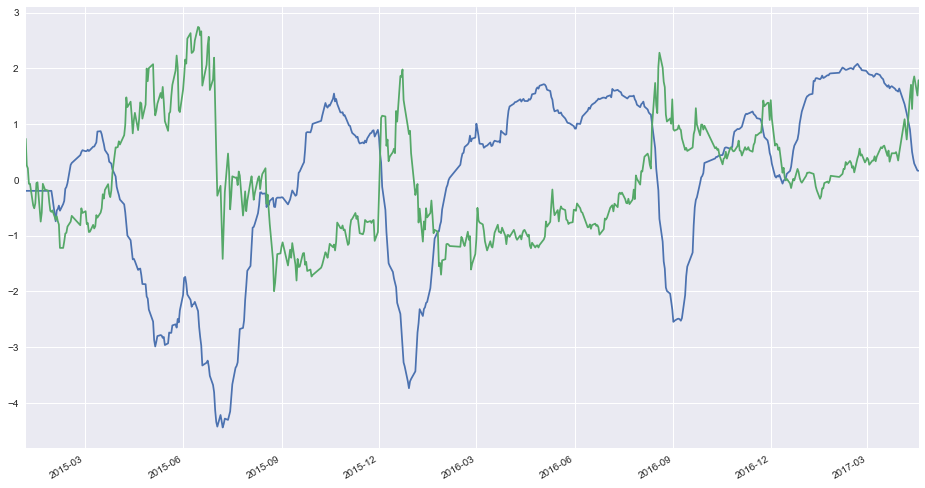

In [667]:
plt.figure(figsize=(16, 9))
Fdf['F'].plot()
Fdf['close_adj'].plot()

# 全市场（加权）平均流动性

In [668]:
index = '000300'
ind_df = pd.read_excel('%s/%s.xlsx'%(INDEX_COMP_DIR, index))

In [669]:
ind_df.head()

,code,name
0,000001.SZ,平安银行
1,000002.SZ,万科A
2,000008.SZ,神州高铁
3,000009.SZ,中国宝安
4,000027.SZ,深圳能源


In [682]:
dic = {}
indicators = [
              '20-day amt', 
              '20-day turnover', 
              '20-day close', 
              '20-day ret', 
              'volatility',
              '20-day amihud',
              '20-day mfd_buyamt_a',
              '20-day mfd_sellamt_a',
             ]
for ticker in ind_df['code']:
    fname = '%s/%s.xlsx'%(DATA_DIR, ticker)
    df = pd.read_excel(fname, index_col=0)
    df['ret'] = df['close'].pct_change()
    df['share_div_price'] = df['mkt_freeshares'] / df['close']
    df['20-day mfd_buyamt_a'] = df['mfd_buyamt_a'].rolling(window=20).sum()
    df['20-day mfd_sellamt_a'] = df['mfd_sellamt_a'].rolling(window=20).sum()
    df['20-day ret'] = df['ret'].rolling(window=20).mean()
    df['20-day close'] = df['close'].rolling(window=20).mean()
    df['20-day volume'] = df['volume'].rolling(window=20).mean()
    df['volatility'] = df['ret'].rolling(window=20).std()
    df['20-day amt'] = df['amt'].rolling(window=20).sum()
    df['amihud'] = np.abs(df['ret']) / df['amt']
    df['20-day amihud'] = df['amihud'].rolling(window=20).mean()
#     df['20-day free_turn'] = df['free_turn'].rolling(window=20).sum()
    df['20-day turnover'] = df['turnover'].rolling(window=20).sum()
    X = df[indicators].fillna(df[indicators].mean())
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    F_score = liquidity_value(X_scaled)
    df['liquidity'] = F_score
    dic[ticker] = df[['amt', 'volume', 'liquidity', 'close']]
pnl = pd.Panel(dic)

C:\Users\jgtzsx01\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in absolute


In [683]:
# liqdf = pd.read_excel('C:/Users/jgtzsx01/Documents/workspace/zjsxzy_in_js/website/everyday-update/data/liquidity.xlsx', index_col=0)

In [684]:
# liqdf['zxb'].plot(figsize=(16, 9))

In [685]:
# liqdf.plot(figsize=(16, 9))

In [686]:
avg_liquidity = pnl.minor_xs('liquidity').mean(axis=1)

In [687]:
data = w.wsd('000300.SH', 'close', avg_liquidity.index[0].strftime('%Y-%m-%d'), avg_liquidity.index[-1].strftime('%Y-%m-%d'))

In [688]:
df = wind2df(data)

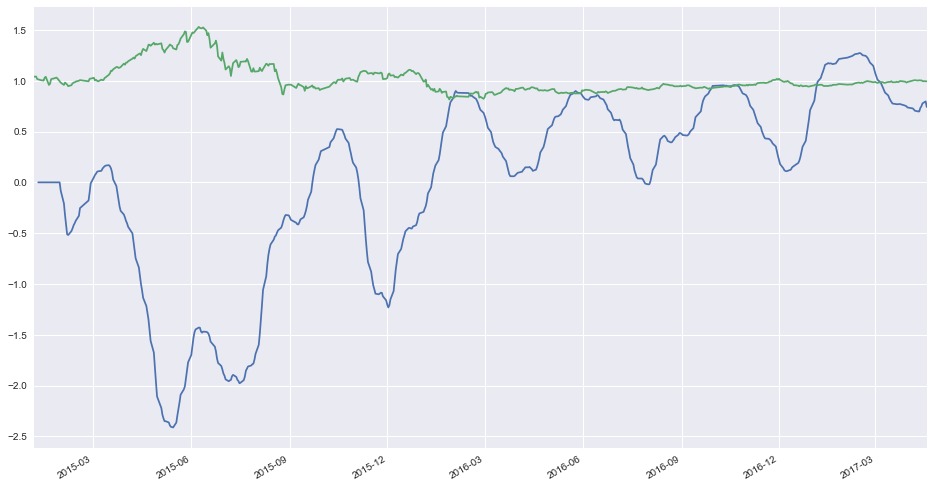

In [689]:
plt.figure(figsize=(16, 9))
avg_liquidity.rolling(window=5).sum().plot()
(df['close']/3500).plot()

In [690]:
k = 5
df['ret'] = df['close'].pct_change(k).shift(-k)

In [691]:
df['liquidity'] = avg_liquidity

In [692]:
df['ret'].corr(df['liquidity'])

0.096313237179092889

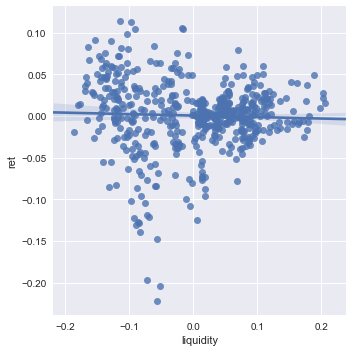

In [681]:
sns.lmplot(x='liquidity', y='ret', data=df)